In [1]:
"""
Install required packages.
LangChain has modular packages - we install what we need.
Uncomment and run if packages are not installed.
"""

# # Core LangChain packages
# %pip install -q langchain>=0.3.0 langchain-openai>=0.2.0 langchain-community>=0.3.0

# # Text processing and agents
# %pip install -q langchain-text-splitters>=0.3.0 langgraph>=0.2.0

# # Vector stores and utilities
# %pip install -q faiss-cpu chromadb tiktoken

# # Environment and parsing
# %pip install -q python-dotenv beautifulsoup4 pypdf

print("All packages installed!")

All packages installed!


In [2]:
"""
Load environment variables and set up API keys.
The .env file should be in the backend folder (parent of notebooks).
"""

import os
from pathlib import Path
from dotenv import load_dotenv

# Try multiple locations for .env file
env_paths = [
    Path("../.env"),
    Path(".env"),
    Path.home() / ".env",
]

env_loaded = False
for env_path in env_paths:
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Loaded .env from: {env_path.resolve()}")
        env_loaded = True
        break

if not env_loaded:
    load_dotenv()
    print("Using system environment variables")

if not os.getenv("OPENAI_API_KEY"):
    raise ValueError("Please set OPENAI_API_KEY in your .env file or environment")

print("Environment loaded successfully!")


Loaded .env from: /Users/yannisshen/Documents/GitHub/pilot/session-17-GenAI/.env
Environment loaded successfully!


# LangChain Integration & Advanced Retrieval

## Table of Contents
1. [Part 1: LangChain for RAG Pipelines](#part-1-langchain-for-rag-pipelines)
2. [Part 2: Query Optimization & Advanced Retrieval](#part-2-query-optimization--advanced-retrieval)
3. [Part 3: Agentic RAG - The Evolution](#part-3-agentic-rag---the-evolution)

---


# Part 1: LangChain for RAG Pipelines



## 1.1 What is LangChain?

LangChain is a **framework for building LLM-powered applications**. It provides:

- **Composable components** for RAG, agents, and chains
- **Integrations** with 100+ LLMs, vector stores, and tools
- **Production tooling** via LangSmith for observability

### The LangChain Ecosystem

| Component | Purpose | When to Use |
|-----------|---------|-------------|
| **LangChain Core** | Framework for chains, prompts, models | Always - the foundation |
| **LangGraph** | Low-level agent workflow engine | Complex multi-step agents |
| **LangSmith** | Observability and evaluation | Production debugging and evals |



## 1.2 Core LangChain Components

LangChain provides **standard building blocks** that snap together like LEGO pieces:

```text
Document Loading → Text Splitting → Embedding → Vector Store → Retriever → Chain → Response
```

### Component Breakdown

| Component | Role | Example |
|-----------|------|---------|
| **Loader** | Ingests raw data (PDF, web, DB) | `PyPDFLoader`, `WebBaseLoader` |
| **Text Splitter** | Chunks documents intelligently | `RecursiveCharacterTextSplitter` |
| **Embedding** | Converts text to vectors | `OpenAIEmbeddings` |
| **VectorStore** | Stores and searches embeddings | `FAISS`, `Chroma`, `Pinecone` |
| **Retriever** | Fetches relevant chunks | `vectorstore.as_retriever()` |
| **Chain** | Orchestrates the full pipeline | LCEL chains, `RetrievalQA` |

### Load Tesla PDF into Vector Store

We load a real PDF and create a searchable index.

In [3]:
"""
Load Tesla Q2 2025 PDF, chunk it, and create vector store.
This consolidates previous two concepts into one setup cell.
"""

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

# Load PDF
loader = PyPDFLoader("TSLA-Q2-2025-Update.pdf")
pdf_pages = loader.load()

# Chunk
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(pdf_pages)

# Create vector store
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

print(f"Tesla Q2 2025 Setup Complete:")
print(f"  - Pages: {len(pdf_pages)}")
print(f"  - Chunks: {len(chunks)}")
print(f"  - Vector store ready")


Tesla Q2 2025 Setup Complete:
  - Pages: 30
  - Chunks: 63
  - Vector store ready


In [4]:
"""
Quick test: verify retrieval works
"""

test_docs = retriever.invoke("What was Tesla's revenue?")
print(f"Retrieved {len(test_docs)} chunks for 'Tesla revenue' query")
print(f"First chunk preview: {test_docs[0].page_content[:200]}...")


Retrieved 4 chunks for 'Tesla revenue' query
First chunk preview: S U M M A R YH I G H L I G H T S
(1) Excludes SBC (stock-based compensation) & Digital assets gains and losses, net of tax; (2) Free cash flow = operating cash flow less capex; (3) Includes cash, cash...


## 1.3 LCEL (LangChain Expression Language) - The Core Pattern

**LCEL is the most important concept to master!** It uses the `|` pipe operator to chain components declaratively.

### Basic Pattern: `prompt | llm | parser`


In [10]:
"""
LCEL Basic Pattern: prompt | llm | parser
This is the core building block for all LangChain chains.
"""

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# Simple chain
prompt = ChatPromptTemplate.from_template(
    "Explain {concept} in one sentence for a financial analyst."
)
simple_chain = prompt | llm | StrOutputParser()

result = simple_chain.invoke({"concept": "gross margin"})
print("Simple LCEL chain:")
print(result)


Simple LCEL chain:
Gross margin is the percentage of revenue that exceeds the cost of goods sold (COGS), indicating the efficiency of a company in managing its production costs relative to its sales.


### RAG Chain Pattern (The Key Pattern!)



In [11]:
"""
LCEL RAG Chain: The core pattern!
{context: retriever, question: passthrough} | prompt | llm | parser
"""

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    
    """Format retrieved docs with page numbers."""
    return "\n\n".join(
        f"[Page {d.metadata.get('page', 0)+1}] {d.page_content}" 
        for d in docs
    )

rag_prompt = ChatPromptTemplate.from_template("""
You are a Tesla financial analyst. Answer based only on the context.
If you can't find the answer, say no.

Context:
{context}

Question: {question}

Answer (cite page numbers):""")

# The key LCEL pattern for RAG
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

print("RAG Chain created! This is the core pattern.")


# Query -> Emebed -> Vector Search -> Top K Docs -> Format -> Prompt + Query -> LLM -> Answer


RAG Chain created! This is the core pattern.


In [7]:
"""
Test the RAG chain with Tesla financial questions.
"""

questions = [
    "What was Tesla's total revenue in Q2 2025?",
    "What is Tesla's gross margin?",
    "How is the energy storage business performing?",
]

print("Tesla Q2 2025 Q&A Demo:")
print("=" * 70)

for q in questions:
    print(f"\nQ: {q}")
    answer = rag_chain.invoke(q)
    print(f"A: {answer}")
    print("-" * 70)


Tesla Q2 2025 Q&A Demo:

Q: What was Tesla's total revenue in Q2 2025?
A: Tesla's total revenue in Q2 2025 was $22,496 million (or $22.496 billion) (Page 24).
----------------------------------------------------------------------

Q: What is Tesla's gross margin?
A: No.
----------------------------------------------------------------------

Q: How is the energy storage business performing?
A: The energy storage business is performing well, with energy storage deployments increasing on a trailing twelve-month (TTM) basis, including record Powerwall deployments for the fifth consecutive quarter. Gross profit for the Energy and Services and Other segment reached a record of $846 million, indicating growth both sequentially and year-over-year (Page 9). Additionally, TTM energy storage deployments achieved their 12th consecutive quarterly record (Page 3).
----------------------------------------------------------------------


In [8]:
"""
LCEL Streaming: Essential for production UX.
All LCEL chains support .stream() automatically!
"""

print("Streaming RAG response:")
print("=" * 70)
print()

for chunk in rag_chain.stream("What are the key highlights from Tesla Q2 2025?"):
    print(chunk, end="", flush=True)

print()


Streaming RAG response:

The key highlights from Tesla Q2 2025 include:

1. **Profitability**: 
   - $0.9B GAAP operating income
   - $1.2B GAAP net income
   - $1.4B non-GAAP net income (Page 3)

2. **Transition to AI and Robotics**: 
   - Q2 2025 marked the beginning of Tesla's transition to becoming a leader in AI, robotics, and related services, alongside its existing leadership in electric vehicles and renewable energy (Page 3).

3. **Robotaxi Service Launch**: 
   - The first Robotaxi service launched in Austin in June, with a focus on a camera-only architecture and neural networks for safety and scalability (Page 3).

4. **Production and Deliveries**: 
   - Model 3/Y production was 396,835, a 3% increase year-over-year.
   - Total production was 410,244, remaining flat year-over-year.
   - Model 3/Y deliveries were 373,728, a 12% decrease year-over-year.
   - Total deliveries were 384,122, a 13% decrease year-over-year (Page 6).

5. **Vehicle Inventory and Infrastructure**: 
   

## 1.4 Manual RAG vs LangChain RAG

### Manual RAG Pipeline (Custom Code)

```python
# Step 1: Embed query
query_embedding = embedding_model.embed(query)

# Step 2: Search vector DB
results = vector_db.search(query_embedding, k=5)

# Step 3: Format context
context = "\n".join([r.text for r in results])

# Step 4: Build prompt
prompt = f"Context: {context}\n\nQuestion: {query}"

# Step 5: Call LLM
response = llm.generate(prompt)
```

### LangChain RAG Pipeline

```python
# Everything in 4 lines with LCEL
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt | llm | StrOutputParser()
)
response = rag_chain.invoke(query)
```

### Comparison

| Aspect | Manual Pipeline | LangChain Pipeline |
|--------|-----------------|-------------------|
| **Lines of Code** | 20-50+ | 5-10 |
| **Streaming** | Must implement | Built-in (`.stream()`) |
| **Flexibility** | Full control | Component-based |
| **Debugging** | Custom logging | LangSmith integration |
| **Learning Curve** | Lower initially | Higher but pays off |

**When to use LangChain:** Prototyping, standard patterns, team collaboration    
**When to use Manual:** Maximum control, minimal dependencies, edge cases


## 1.5 Conversational RAG with Memory

### The Problem
In multi-turn conversations, pronouns like "it" or "they" need context from previous messages.

### Solution: History-Aware Retriever



In [9]:
"""
History-aware retriever using LCEL pattern.
Reformulates queries based on chat history.
"""

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage

# Step 1: Create a query reformulation chain
contextualize_prompt = ChatPromptTemplate.from_messages([
    ("system", """Given a chat history and the latest user question, 
reformulate it as a standalone question. Do NOT answer the question,
just reformulate it if needed and otherwise return it as is."""),
    MessagesPlaceholder("chat_history"),
    ("human", "{input}"),
])

# This chain reformulates the query
reformulate_chain = contextualize_prompt | llm | StrOutputParser()

# Step 2: Create history-aware retrieval using LCEL
def create_history_aware_retriever_fn(question, chat_history):
    """Reformulate question based on history, then retrieve."""
    if chat_history:
        reformulated = reformulate_chain.invoke({
            "input": question,
            "chat_history": chat_history
        })
    else:
        reformulated = question
    return retriever.invoke(reformulated)

print("History-aware retriever created with LCEL!")
print("\nExample: 'What was the revenue?' + history about Tesla")
print("  -> Reformulated: 'What was Tesla's Q2 2025 revenue?'")

History-aware retriever created with LCEL!

Example: 'What was the revenue?' + history about Tesla
  -> Reformulated: 'What was Tesla's Q2 2025 revenue?'


In [10]:
"""
Multi-turn conversation demo using LCEL.
Watch how 'it' and 'they' resolve correctly!
"""

def conversational_rag(question, chat_history):
    """Complete conversational RAG using LCEL pattern."""
    # Step 1: Get relevant docs using history-aware retrieval
    docs = create_history_aware_retriever_fn(question, chat_history)
    context = format_docs(docs)
    
    # Step 2: Generate answer with chat history context
    messages = [("system", f"Answer based on context. Be concise.\n\nContext:\n{context}")]
    messages.extend([(m.type, m.content) for m in chat_history])
    messages.append(("human", question))
    
    qa_prompt = ChatPromptTemplate.from_messages(messages)
    response = (qa_prompt | llm | StrOutputParser()).invoke({})
    return response

# Multi-turn demo
chat_history = []

print("Multi-turn Conversation Demo:")
print("=" * 70)

q1 = "What is Tesla's energy storage business?"
a1 = conversational_rag(q1, chat_history)
print(f"\nUser: {q1}")
print(f"Bot: {a1}")
chat_history.extend([HumanMessage(content=q1), AIMessage(content=a1)])

q2 = "How did it perform this quarter?"
a2 = conversational_rag(q2, chat_history)
print(f"\nUser: {q2}")
print(f"Bot: {a2}")
print("\n(Note: 'it' correctly resolved to 'energy storage business')")


Multi-turn Conversation Demo:

User: What is Tesla's energy storage business?
Bot: Tesla's energy storage business focuses on deploying products like Megapack and Powerwall to store energy, which helps meet global demand for clean and reliable energy. The business has seen significant growth, with record deployments and gross profit, and aims to enhance the efficiency of the electric grid, especially when paired with solar energy.

User: How did it perform this quarter?
Bot: This quarter, Tesla's energy storage business achieved record deployments, with a trailing twelve-month (TTM) increase in energy storage, including record Powerwall deployments for the fifth consecutive quarter. Gross profit reached a record of $846 million, indicating strong performance despite macroeconomic uncertainties.

(Note: 'it' correctly resolved to 'energy storage business')


### Memory Types 

| Type | Use Case | Trade-off |
|------|----------|-----------|
| **ConversationBufferMemory** | Short chats | Unlimited growth |
| **ConversationBufferWindowMemory** | Medium chats, recent context | Loses old context |
| **ConversationSummaryMemory** | Long sessions | LLM cost for summaries |
| **EntityMemory** | Track entities (names, IDs) | Setup overhead |




## 1.6 Production Patterns

Critical for real-world deployments.

### Caching (Reduce Costs by 30%+)


In [11]:
"""
Caching: Reduce costs and latency by 10x for repeated queries.
"""

from langchain_community.cache import InMemoryCache
from langchain_core.globals import set_llm_cache

set_llm_cache(InMemoryCache())
print("LLM Caching enabled!")

print("\nCaching options:")
print("  - InMemoryCache: Development, fast, no persistence")
print("  - SQLiteCache: Simple persistence, single machine")
print("  - RedisCache: Production, distributed, TTL support")
print()
print("Cost example: 10k queries/day, 30% cache hit = $30/day saved")


# prompt -> out response (template)
# query -> top-k chunks (search)

LLM Caching enabled!

Caching options:
  - InMemoryCache: Development, fast, no persistence
  - SQLiteCache: Simple persistence, single machine
  - RedisCache: Production, distributed, TTL support

Cost example: 10k queries/day, 30% cache hit = $30/day saved


### Fallback Chains (High Availability)



In [12]:
"""
Fallback chains: Graceful degradation when primary model fails.
"""

from langchain_openai import ChatOpenAI

# Create primary and fallback models
primary = ChatOpenAI(model="gpt-4o", max_retries=1, request_timeout=5)
fallback = ChatOpenAI(model="gpt-4o-mini", max_retries=2)

# Chain with fallback - if primary fails, uses fallback automatically
robust_llm = primary.with_fallbacks([fallback])

print("Fallback Chain Demo:")
print("=" * 70)

# Test it
result = robust_llm.invoke("What is 2+2? Answer in one word.")
print(f"\nResponse: {result.content}")
print()
print("How it works:")
print("  1. Try gpt-4o first")
print("  2. If fails (rate limit, timeout), auto-retry with gpt-4o-mini")
print("  3. No code changes needed - fallback is transparent!")


Fallback Chain Demo:

Response: Four.

How it works:
  1. Try gpt-4o first
  2. If fails (rate limit, timeout), auto-retry with gpt-4o-mini
  3. No code changes needed - fallback is transparent!


### Structured Output (Reliable JSON)




In [13]:
"""
Structured Output with Pydantic: Get reliable JSON from LLM.
Critical for data extraction pipelines.
"""

from pydantic import BaseModel, Field
from typing import List

class FinancialSummary(BaseModel):
    """Structured extraction from earnings report."""
    revenue: str = Field(description="Total revenue amount")
    profit: str = Field(description="Net profit/income")
    key_highlights: List[str] = Field(description="3 key business highlights")

structured_llm = llm.with_structured_output(FinancialSummary)

# Extract structured data from Tesla report
context = retriever.invoke("Tesla Q2 2025 financial summary")
result = structured_llm.invoke(
    f"Extract financial summary from:\n{context[0].page_content}"
)
# Returns: FinancialSummary(revenue="$22.5B", profit="$1.2B", ...)

print("Structured Output Demo:")
print("=" * 70)
print(f"Revenue: {result.revenue}")
print(f"Profit: {result.profit}")
print(f"Highlights: {result.key_highlights}")


Structured Output Demo:
Revenue: $0.9B
Profit: $1.2B
Highlights: ['Transitioning to AI and robotics leadership', 'Launch of first Robotaxi service in Austin', 'Focus on camera-only architecture for autonomy']


### Observability: Custom Callbacks

**Critical for production debugging.** When something goes wrong, you need to know:
- How many tokens were used?
- What was the latency?
- What did each step receive and return?

In [24]:
"""
Custom Callback for Production Monitoring.
Track tokens, latency, and costs in real-time.
"""

from langchain_core.callbacks import BaseCallbackHandler
from typing import Any, Dict, List
import time

class ProductionCallbackHandler(BaseCallbackHandler):
    """Custom callback to track LLM usage metrics."""
    
    def __init__(self):
        self.total_tokens = 0
        self.prompt_tokens = 0
        self.completion_tokens = 0
        self.total_cost = 0.0
        self.start_time = None
        self.latency_ms = 0
    
    def on_llm_start(self, serialized: Dict[str, Any], prompts: List[str], **kwargs):
        """Called when LLM starts generating."""
        self.start_time = time.time()
        print(f"[Monitor] LLM started, prompt length: {len(prompts[0])} chars")
    
    def on_llm_end(self, response, **kwargs):
        """Called when LLM finishes."""
        self.latency_ms = (time.time() - self.start_time) * 1000
        
        # Extract token usage if available
        if hasattr(response, 'llm_output') and response.llm_output:
            usage = response.llm_output.get('token_usage', {})
            self.prompt_tokens = usage.get('prompt_tokens', 0)
            self.completion_tokens = usage.get('completion_tokens', 0)
            self.total_tokens = usage.get('total_tokens', 0)
            
            # Calculate cost (GPT-4o-mini pricing)
            self.total_cost = (self.prompt_tokens * 0.00015 + self.completion_tokens * 0.0006) / 1000
        
        print(f"[Monitor] LLM finished in {self.latency_ms:.0f}ms")
        print(f"[Monitor] Tokens: {self.total_tokens} (prompt: {self.prompt_tokens}, completion: {self.completion_tokens})")

# Demo: Use custom callback
callback = ProductionCallbackHandler()

llm_with_callback = ChatOpenAI(
    model="gpt-4o-mini", 
    temperature=0,
    callbacks=[callback]
)

print("Observability Demo:")
print("=" * 70)

response = llm_with_callback.invoke("What is Tesla's stock ticker symbol? Answer in one word.")
print(f"\nResponse: {response.content}")
print(f"\nMetrics collected:")
print(f"  - Latency: {callback.latency_ms:.0f}ms")
print(f"  - Tokens: {callback.total_tokens}")
print(f"  - Est. Cost: ${callback.total_cost:.6f}")
print()
print("In production: Send these metrics to Datadog/Prometheus/CloudWatch")


Observability Demo:
[Monitor] LLM started, prompt length: 63 chars
[Monitor] LLM finished in 763ms
[Monitor] Tokens: 22 (prompt: 20, completion: 2)

Response: TSLA

Metrics collected:
  - Latency: 763ms
  - Tokens: 22
  - Est. Cost: $0.000004

In production: Send these metrics to Datadog/Prometheus/CloudWatch


### Common Problem Scenarios

| Problem | LangChain Solution |
|---------|-------------------|
| Chatbot forgets context after many messages | Use message list with sliding window or summarization |
| LLM costs too high | `set_llm_cache(InMemoryCache())` + model routing |
| Primary model fails (rate limit, timeout) | `llm.with_fallbacks([fallback_llm])` |
| Need structured JSON output | `llm.with_structured_output(PydanticModel)` |
| Need real-time or external data | Tool-calling: `llm.bind_tools([api_tool])` |
| Complex multi-step reasoning | Agent pattern with multiple tools |   



> **Tip**: Always ask clarifying questions first - scale, latency, accuracy requirements.


## 1.7 Framework Comparison

| Framework | Best For | Strengths |
|-----------|----------|-----------|
| **LangChain** | General RAG & agents | Large ecosystem, LCEL, LangSmith |
| **LlamaIndex** | Complex document indexes | Rich index types, document focus |
| **Haystack** | Enterprise search | Strong search pipelines |
| **DSPy** | Prompt optimization | Auto-tunes prompts |

### LlamaIndex vs LangChain

**Syntax Comparison:**   
```python
# LlamaIndex (3 lines)
index = VectorStoreIndex.from_documents(docs)
query_engine = index.as_query_engine()
response = query_engine.query(question)

# LangChain (5+ lines)
vectorstore = FAISS.from_documents(docs, embeddings)
retriever = vectorstore.as_retriever()
chain = {"context": retriever, "question": ...} | prompt | llm
response = chain.invoke(question)
```

**Trade-off:** LlamaIndex is more concise; LangChain is more flexible

**Key differences:**   
- LlamaIndex: Document-centric, rich index types
- LangChain: Component-centric, flexible chains


#### LlamaIndex Comparison Demo

**Same task, different framework.** Let's see how LlamaIndex handles the Tesla PDF.



In [6]:
# Install LlamaIndex
# %pip install -q llama-index llama-index-llms-openai llama-index-embeddings-openai

"""
LlamaIndex RAG Demo: Same Tesla PDF, different framework.
"""

from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Settings
from llama_index.llms.openai import OpenAI as LlamaOpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

# Configure LlamaIndex settings
Settings.llm = LlamaOpenAI(model="gpt-4o-mini", temperature=0)
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")

# Load and index in ONE line - this is LlamaIndex's strength
from llama_index.core import Document

# Reuse our already-loaded PDF pages
llama_docs = [Document(text=page.page_content, metadata=page.metadata) for page in pdf_pages]
index = VectorStoreIndex.from_documents(llama_docs)

# Create query engine
query_engine = index.as_query_engine(similarity_top_k=4)


# Query with LlamaIndex
response = query_engine.query("What is Tesla's energy storage gross profit?")
print(f"\nLlamaIndex Answer: {response.response}")
print(f"\nSources: {len(response.source_nodes)} nodes retrieved")



LlamaIndex Answer: Tesla's energy storage gross profit reached a record of $846 million for the quarter.

Sources: 4 nodes retrieved


---  

# Part 2: Query Optimization & Advanced Retrieval

## 2.1 Why Naive RAG Fails

### Core Limitations

1. **Single Modality**: Can't synthesize info from images, tables, charts + text
2. **Insufficient Context Breadth**: Top-K chunks can't answer "summarize this report"
3. **Vector Search Limitations**: Distance ≠ semantic relevance (negation, complex logic)   

To overcome these limitations, we need to optimize and upgrade the RAG process in two core areas: Data Quality (talked in [the previous note](./2_advanced-data-quality_indexing-pipeline.ipynb)) and **Query Complexity** (following)



### Types of Complex Questions Naive RAG Can't Handle

Real-world user questions go far beyond simple "who is" or "what is" queries. 
They often contain more complex intentions:

| Type | Example | Why It Fails |
|------|---------|--------------|
| **Summarization** | "Summarize this book's main points" | Needs entire document |
| **Comparison** | "Compare engineer A and B's contributions" | Needs multiple retrievals |
| **Structured Analytics** | "Risk factors for top rideshare companies" | Needs filtering + aggregation |
| **Multi-part** | "Find topic A in doc X, topic B in doc Y, synthesize" | Multiple independent searches |

Limitations: **Query understanding + planning, Tool use, Reflection + error 
correction, Memory**  


Naive RAG cannot handle these questions because it relies on a single, simple 
vector retrieval, which is insufficient to gather all the information needed to 
answer such complex queries.




## 2.2 Query Transformation Techniques
before performing retrieval, we can first use an LLM to perform a series of "preprocessing" or "transformation" steps on the user's original query.

### 2.2.1 Query Rewrite

It is the most direct method.   

**Problem:** User queries are often **conversational** or contain **irrelevant info**.

**Solution:** LLM rewrites to retrieval-friendly format.

```text
Original: "I just binged The White Lotus and slept great! Quick, what is LangChain?"
    ↓
Rewritten: "What is the LangChain framework and how does it work?"
```


In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

rewrite_prompt = ChatPromptTemplate.from_template("""
Rewrite this query to be clear and retrieval-friendly.
Remove conversational filler. Keep the core question.

Query: {query}
Rewritten:""")

rewrite_chain = rewrite_prompt | llm | StrOutputParser()

rewrite_chain.invoke({
    "query": "I just binged The White Lotus and slept great! Quick, what is LangChain?"
})

'What is LangChain?'

### 2.2.2 [HyDE](https://arxiv.org/pdf/2212.10496) (Hypothetical Document Embeddings)

**Key Insight:** An ideal answer is semantically closer to source documents than a vague question.    

**Process:**    

We don't embed the user's query directly. Instead:  

1. Use LLM to attempt answer the query first and generate multiple responses (hypothetical answer(s))
2. Embed all those responses into vectors
3. Converge the vectors into one by computing their average
4. Retrieve context using the new vector

**When to use:** When queries are abstract or lack domain-specific terminology.

> the following example reuses [loading tesla pdf](#load-tesla-pdf-into-vector-store) 

In [14]:
# Hyde chain
hyde_prompt = ChatPromptTemplate.from_template("""
Write a passage that would answer this question:
{query}

Passage:""")

# retrieval using LCEL
def hyde_retrieval(query):
    # Step 1: Generate hypothetical answer
    hypothetical = (hyde_prompt | llm | StrOutputParser()).invoke({"query": query})
    
    # Step 2: Embed the hypothetical answer (not the query!)
    hyde_embedding = embeddings.embed_query(hypothetical)
    
    # Step 3: Search with hypothetical embedding
    results = vectorstore.similarity_search_by_vector(hyde_embedding, k=5)
    
    # Format output nicely
    print(f"Query: {query}\n")
    print(f"Hypothetical Answer Generated:\n{hypothetical}\n")
    print("=" * 60)
    print("Retrieved Documents:\n")
    
    return results

results = hyde_retrieval("What was Tesla's total revenue in Q2 2025?")
for i, doc in enumerate(results, 1):
    print(f"--- Result {i} ---")
    print(f"Source: {doc.metadata.get('source', 'N/A')}")
    print(f"Page: {doc.metadata.get('page_label', 'N/A')}")
    print(f"Content:\n{doc.page_content[:500]}...")  # Truncate long content
    print()

Query: What was Tesla's total revenue in Q2 2025?

Hypothetical Answer Generated:
As of October 2023, Tesla has not yet released its financial results for the second quarter of 2025. Therefore, the total revenue for Tesla in Q2 2025 remains unknown. Typically, Tesla announces its quarterly earnings a few weeks after the end of each quarter, providing detailed insights into its financial performance, including total revenue, vehicle deliveries, and other key metrics. To find the most accurate and up-to-date information regarding Tesla's revenue for that specific quarter, it is advisable to check Tesla's official investor relations website or reliable financial news sources closer to the date of the earnings release.

Retrieved Documents:

--- Result 1 ---
Source: TSLA-Q2-2025-Update.pdf
Page: 29
Content:
A D D I T I O N A L  I N F O R M A T I O N
WEBCAST INFORMATION
Tesla will provide a live webcast of its second quarter 2025 financial results conference call beginning at 4:30 p.m. CT o

### 2.2.3 Step-Back Prompting

**Problem:** Very specific queries may not find exact matches.

**Solution:** Generate broader "step-back" question first, get high-level context.

This technique has an LLM first generate a broader, more general "step-back" question and retrieves high-level context related to it. Then, the system uses this broader context to better inform the answer to the user's original, specific question

```text
Original: "What are the most popular programming languages used in ML?"
    ↓
Step-back: "What are popular programming languages in Machine Learning, 
            Artificial Intelligence, and Data Science?"
```

**Process:**
1. Generate broader related queries
2. Retrieve high-level context from broader queries
3. Use that context to inform answer to original specific query



### 2.2.4 Subquery Decomposition
This is key for handling **comparison or multi-part questions**.

**Problem:** Complex questions need information from multiple places.

**Solution:** Break into independent subqueries, run RAG on each, synthesize the 
answers from all subqueries to form the final response.

```text
Original: "Compare the revenue growth of Uber and Lyft in 2024"
    ↓
Subquery 1: "What was Uber's revenue growth in 2024?"
Subquery 2: "What was Lyft's revenue growth in 2024?"
    ↓
Synthesize both answers into comparison
```

In [16]:
# 1. Decomposition prompt
decompose_prompt = ChatPromptTemplate.from_template("""
Break this complex question into 2-4 simpler, independent questions.
Each question should be self-contained and answerable on its own.

Question: {query}

Subqueries (one per line):
1.""")

# 2. RAG prompt for each subquery
rag_prompt = ChatPromptTemplate.from_template("""
Answer the question based only on the following context:

Context:
{context}

Question: {question}

Answer:""")

# 3. Synthesis prompt
synthesis_prompt = ChatPromptTemplate.from_template("""
You were asked a complex question that was broken into smaller parts.
Using the sub-answers below, provide a comprehensive final answer.

Original Question: {original_query}

Sub-questions and answers:
{sub_answers}

Final synthesized answer:""")

# Helper function to format retrieved docs
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Parse subqueries from LLM output
def parse_subqueries(text):
    subqueries = []
    for line in text.strip().split("\n"):
        # Remove numbering like "1.", "2.", etc.
        clean = line.strip().lstrip("0123456789.)").strip()
        if clean and len(clean) > 5:  # Filter out empty or too short lines
            subqueries.append(clean)
    return subqueries

# RAG chain for individual subquery
def rag_subquery(question):
    # Retrieve relevant docs
    docs = vectorstore.similarity_search(question, k=3)
    context = format_docs(docs)
    
    # Generate answer
    answer = (rag_prompt | llm | StrOutputParser()).invoke({
        "context": context,
        "question": question
    })
    
    return {"question": question, "answer": answer}

# Main decomposed RAG function
def decomposed_rag(query):
    print(f"Original Query: {query}\n")
    print("=" * 60)
    
    # Step 1: Decompose the query
    decompose_chain = decompose_prompt | llm | StrOutputParser()
    decomposed = decompose_chain.invoke({"query": query})
    subqueries = parse_subqueries(decomposed)
    
    print(f"Decomposed into {len(subqueries)} subqueries:")
    for i, sq in enumerate(subqueries, 1):
        print(f"  {i}. {sq}")
    print()
    
    # Step 2: RAG each subquery
    sub_results = []
    for sq in subqueries:
        result = rag_subquery(sq)
        sub_results.append(result)
        print(f"Q: {result['question']}")
        print(f"A: {result['answer']}\n")
    
    # Step 3: Format sub-answers for synthesis
    sub_answers_text = "\n\n".join([
        f"Q: {r['question']}\nA: {r['answer']}" 
        for r in sub_results
    ])
    
    # Step 4: Synthesize final answer
    print("=" * 60)
    print("Synthesizing final answer...\n")
    
    final_answer = (synthesis_prompt | llm | StrOutputParser()).invoke({
        "original_query": query,
        "sub_answers": sub_answers_text
    })
    
    print(f"Final Answer:\n{final_answer}")
    
    return {
        "original_query": query,
        "subqueries": subqueries,
        "sub_results": sub_results,
        "final_answer": final_answer
    }


# Example usage
result = decomposed_rag(
    "How did Tesla's vehicle deliveries and profitability change from Q1 to Q2 2025, and what new initiatives did they launch?"
)

Original Query: How did Tesla's vehicle deliveries and profitability change from Q1 to Q2 2025, and what new initiatives did they launch?

Decomposed into 3 subqueries:
  1. How did Tesla's vehicle deliveries change from Q1 to Q2 2025?
  2. How did Tesla's profitability change from Q1 to Q2 2025?
  3. What new initiatives did Tesla launch in Q2 2025?

Q: How did Tesla's vehicle deliveries change from Q1 to Q2 2025?
A: Tesla's vehicle deliveries decreased from Q1 2025 to Q2 2025, dropping from 336,681 to 384,122, which represents a decline of approximately 13%.

Q: How did Tesla's profitability change from Q1 to Q2 2025?
A: Tesla's profitability improved from Q1 to Q2 2025, with GAAP operating income increasing to $0.9 billion and GAAP net income rising to $1.2 billion. Additionally, non-GAAP net income reached $1.4 billion in Q2 2025.

Q: What new initiatives did Tesla launch in Q2 2025?
A: In Q2 2025, Tesla launched its first Robotaxi service in Austin. This service is part of their t

### 2.2.5 Rationale Generation 

Generate reasoning about what information is needed before retrieval. This helps the model "think through" what documents would be useful.

An ideal answer is often semantically closer to the true source text than a vague question.  

```python
rationale_prompt = """
Question: {query}

Think step-by-step about what information you need to answer this question:
1. What specific facts are required?
2. What type of documents would contain this?
3. What keywords should we search for?

Rationale:"""
```
So "rationale" is typically a reasoning step that can inform better query construction or retrieval strategy. It's related to chain-of-thought prompting applied to the retrieval process.



### 2.2.6 Query Expansion 
Add synonyms or related terms to improve recall  

Why it helps:    
The original query might miss documents that say "net income" or "earnings" instead of "profit". By expanding the query, you increase recall and catch relevant documents that use different terminology

In [15]:
# Query Expansion Prompt
expansion_prompt = ChatPromptTemplate.from_template("""
Given the following query, generate 3 alternative versions that capture the same intent 
but use different words, synonyms, or phrasings. This helps retrieve more relevant documents.

Original Query: {query}

Alternative queries (one per line):
1.""")

def expand_query(query):
    expanded = (expansion_prompt | llm | StrOutputParser()).invoke({"query": query})
    
    # Parse the alternatives
    alternatives = [query]  # Include original
    for line in expanded.strip().split("\n"):
        # Clean up numbering like "2." or "3."
        clean = line.strip().lstrip("0123456789.").strip()
        if clean:
            alternatives.append(clean)
    
    return alternatives

# Example usage
query = "What was Tesla's profit in Q2 2025?"
expanded_queries = expand_query(query)

print("Original:", query)
print("\nExpanded queries:")
for i, q in enumerate(expanded_queries):
    print(f"  {i+1}. {q}")

Original: What was Tesla's profit in Q2 2025?

Expanded queries:
  1. What was Tesla's profit in Q2 2025?
  2. What was Tesla's earnings for the second quarter of 2025?
  3. How much profit did Tesla make in the second quarter of 2025?
  4. What were Tesla's financial gains in Q2 of 2025?


## 2.3 Advanced Retrieval Strategies
Simply optimizing the query is not enough; we also need to improve the retrieval process itself, moving beyond a simple Top-K vector search.

### 2.3.1 Multi-Faceted Retrieval

This involves combining multiple retrieval techniques.   

For example, before performing a vector search, first use metadata to filter the knowledge base (e.g., filtering documents by publication date, source company, etc.). This can significantly narrow the search space and improve precision.

Multiple retrieval techniques:  

| Technique | Purpose |
|-----------|---------|
| **Metadata Filtering** | Filter by date, source, category before search |
| **Similarity Thresholds** | Reject low-confidence results |
| **Content Filtering** | Remove irrelevant chunks post-retrieval |
| **Diversity Filtering** | Remove near-duplicate chunks |

```python
# Example: Metadata + Vector Search
retriever = vectorstore.as_retriever(
    search_kwargs={
        "k": 10,
        "filter": {"source": "annual_report", "year": 2024}
    }
)
```

In [21]:
!python ./3_MultiFacetedRetrieval.py

Query: How many vehicles did Tesla deliver and what was their profit?

Retrieved 3 documents:

--- Result 1 [semantic] ---
Page: 3
Content: S U M M A R YH I G H L I G H T S
(1) Excludes SBC (stock-based compensation) & Digital assets gains and losses, net of tax; (2) Free cash flow = operating cash flow less capex; (3) Includes cash, cash equivalents and investments; Note: all information herein refers to the current quarter unless othe...

--- Result 2 [semantic] ---
Page: 7
Content: and infrastructure buildout as well as tool installation.
Market share of Tesla vehicles by region (TTM)
Source: Tesla estimates based on latest available data from ACEA; Autonews.com; CAAM – light-
duty vehicles only; TTM = Trailing twelve months; Q2 data for Europe unavailable as of 
7/23/25.(1) A...

--- Result 3 [semantic] ---
Page: 6
Content: Q2-2024 Q3-2024 Q4-2024 Q1-2025 Q2-2025 YoY
Model 3/Y production 386,576 443,668 436,718 345,454 396,835 3%
Other models production 24,255 26,128 22,727 17,161 

### 2.3.2 Ensemble Retrieval

Ensemble retrieval combines multiple retrieval strategies to get better coverage and accuracy than any single method alone.

```text
┌─────────────────────────────────────────────────────────────┐
│                      User Query                             │
└─────────────────────────┬───────────────────────────────────┘
                          │
        ┌─────────────────┼─────────────────┐
        │                 │                 │
        ▼                 ▼                 ▼
┌───────────────┐ ┌───────────────┐ ┌───────────────┐
│  Retriever A  │ │  Retriever B  │ │  Retriever C  │
│  (Semantic)   │ │    (BM25)     │ │    (MMR)      │
└───────┬───────┘ └───────┬───────┘ └───────┬───────┘
        │                 │                 │
        │   Docs + Ranks  │   Docs + Ranks  │
        │                 │                 │
        └─────────────────┼─────────────────┘
                          ▼
              ┌───────────────────────┐
              │    Fusion Strategy    │
              │  (RRF, Weighted, etc) │
              └───────────┬───────────┘
                          │
                          ▼
              ┌───────────────────────┐
              │   Final Ranked Docs   │
              └───────────────────────┘
```
**Why Ensemble?**      
Each retriever has strengths and weaknesses:     

| Retriever | Strengths | Weaknesses | 
| ---| ----| ----| 
| Dense (Vector) | Semantic understanding, synonyms| Misses exact matches, rare terms| 
| Sparse (BM25)| Exact keywords, rare terms| No semantic understanding| 
| MMR| Diversity, reduces redundancy| May sacrifice top relevance| 
| Multi-Query| Handles ambiguity| More LLM calls, slower| 
| Parent Document| Full context| May return too much| 

Fusion Strategies:   
1. Reciprocal Rank Fusion (RRF)    
    The most popular method. Scores documents based on their rank position across retrievers
    ```
    RRF_score(d) = Σ 1 / (k + rank_i(d))
    ```
    Where `k` is typically 60, and `rank_i(d)` is document's rank in retriever `i`.
2. Linear Combination (Score-based)     
    Combines actual similarity scores (requires normalized scores)
3. Voting / Occurrence-based    
    Documents that appear in more retrievers get higher scores

```python
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(docs)
vector_retriever = vectorstore.as_retriever()

# 50/50 weighting
ensemble = EnsembleRetriever(
    retrievers=[bm25_retriever, vector_retriever],
    weights=[0.5, 0.5]
)
```



### 2.3.3 Two-Stage Retrieval with Reranking

This is a two-stage process that can significantly improve the relevance of the final results. The distance between vectors serve as a fast and decent first step – works well on **large amount of data**.

**Problem:** Vector distance isn't always accurate (e.g., "long-term" vs "short-term" effects)

**Solution:** Two-stage process

```text
Stage 1 (Recall): Fast vector search → a larger set of candidate chunks (e.g., the top 50)
Stage 2 (Rerank): More powerful, more precise, but slower model → Re-score and re-rank → the truly most relevant results (Top 5 final)
```

This is crucial for distinguishing **subtle semantic differences** . 
e.g.:  
  ```text
  Query: "What are the long-term effects of intermittent fasting?"

  Without Reranking:
    ❌ "Study on SHORT-TERM effects of fasting..." (high vector similarity)
    
  With Reranking:
    ✅ "Long-term cardiovascular benefits of intermittent fasting..." 
      (cross-encoder catches the semantic difference)
  ```


**Rerank Model Options:**    
Cross-encoders or General LLMs:   
- Cross-encoders are specialized models for relevance of two corpus of data
- faster, cheaper, less flexible

Metadata-enhanced Reranking:
- Use metadata and what not to enhance the reranking process

| Type | Speed | Quality | Cost |
|------|-------|---------|------|
| **Cross-encoder** | Fast | Good | Low |
| **Cohere Rerank** | Medium | Very Good | Medium |
| **LLM-based** | Slow | Excellent | High |

```python
from langchain.retrievers import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

# Stage 1: Get candidates
base_retriever = vectorstore.as_retriever(search_kwargs={"k": 50})

# Stage 2: Rerank
reranker = CohereRerank(top_n=5)
retriever = ContextualCompressionRetriever(
    base_compressor=reranker,
    base_retriever=base_retriever
)
```

### 2.3.4 Hierarchical Indices

Our index does not have to be flat. We can build a hierarchical index structure.     

**Process:**       
1. Search document summaries → Find relevant documents
2. Search section summaries within those docs → Find relevant sections
3. Search paragraphs within sections → Get final chunks

This mimics the **human process of looking for information from macro to micro**.

The indices are not necessarily on the same level, it can be at multiple levels – document, sections, pages, paragraphs.

**Structure index at multiple granularities:**

```text
Level 1: Document Summaries  → Coarse search
    ↓
Level 2: Section Summaries   → Medium search
    ↓
Level 3: Paragraphs/Chunks   → Fine-grained search
```




## 2.4 Reliability Guarantees

To make a RAG system production-ready, we must add validation and guarantee mechanisms.

### Hallucination Check (LLM Verification)
After generating an answer, we can call an LLM a second time to have it judge whether its own generated answer is accurate and free of hallucinations based on the retrieved context.

```python
verify_prompt = ChatPromptTemplate.from_template("""
Context: {context}
Answer: {answer}

Is this answer fully supported by the context? 
Identify any claims not grounded in the context.

Verification:""")

def verified_rag(query):
    docs = retriever.invoke(query)
    answer = rag_chain.invoke(query)
    verification = verify_chain.invoke({
        "context": format_docs(docs),
        "answer": answer
    })
    return {"answer": answer, "verification": verification}
```

### Source Tracing (Citations)
The system must be able to clearly show which specific locations in the original documents the answer came from, i.e., provide Citations.

Always include page/chunk references:

```python
def format_docs_with_citations(docs):
    return "\n\n".join(
        f"[Source {i+1}, Page {d.metadata.get('page', '?')}] {d.page_content}"
        for i, d in enumerate(docs)
    )
```

### Human in the Loop
Establish a mechanism that allows users or internal employees to provide feedback on unsatisfactory answers. This feedback data can be used to continuously optimize the system.  

Collect feedback on poor answers → Use for continuous improvement

---



# Part 3: Agentic RAG - The Evolution

## 3.1 From Naive RAG to Agentic RAG

When we combine all the advanced techniques discussed above (query transformation, multi-stage retrieval, reranking, self-verification, etc.), we evolve from Naive RAG to a more powerful **Agentic RAG**.

**Naive RAG (Fixed Pipeline)**    
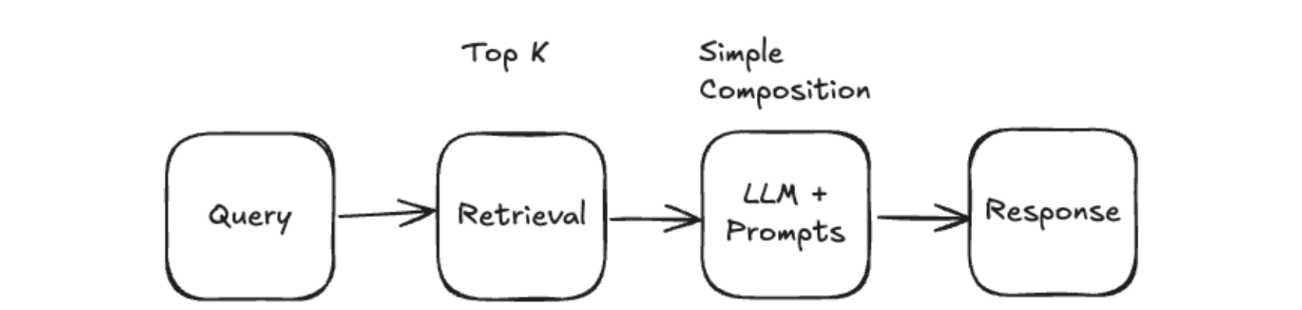

**Agentic RAG (Dynamic, Self-Correcting)**   
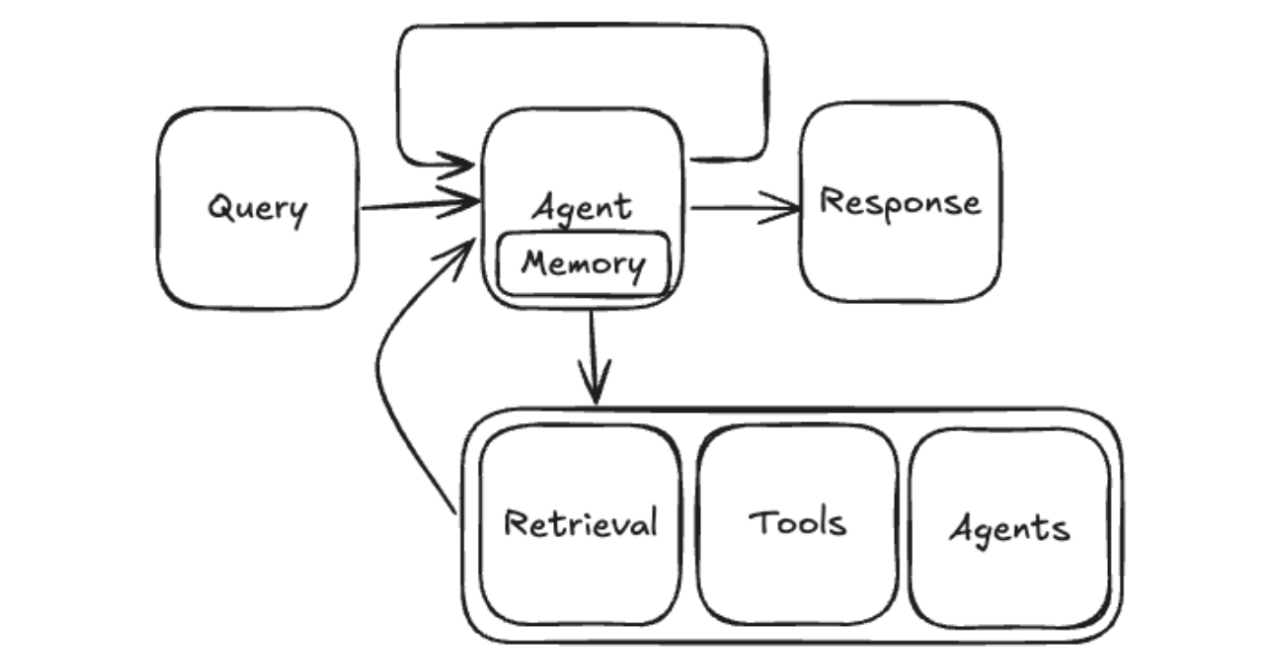

In this new paradigm, the core is no longer a fixed process but an **Agent**  

**When to use Agent vs Chain:**
- **Chain**: Predictable steps, faster, cheaper
- **Agent**: Needs to decide actions dynamically, multi-step reasoning

## 3.2 Agent Architecture

The Agent has:
- **Memory**: Maintains conversation context
- **Toolbox**: Collection of capabilities (retrieval is just ONE tool)
- **Reasoning**: Decides which tool to use and when

### Example Agentic RAG Workflow

1. The Agent receives a user query.
2. It thinks and decides which tool to use for the first step. Perhaps the query rewrite tool.
3. It executes the **rewrite**, 
4. then thinks again and decides the next step is to **decompose the problem into subqueries**.
5. For each subquery, it calls the **hierarchical retrieval tool** to find information.
6. It **synthesizes** all the retrieved information and calls an LLM to generate a **preliminary answer**.
7. Finally, it calls a **self-verification tool** to check the answer 
8. and attach **source citations** before giving the final response.

This is a dynamic, multi-step, self-correcting loop that represents the forefront of 
RAG development.  

<img src="./pic/3_rag_agent-rag.gif">

## 3.3 Tool-Calling in LangChain



In [22]:
"""
Creating custom tools for agents.
Tools are functions that agents can call.
"""

from langchain_core.tools import tool
from datetime import datetime

@tool
def get_current_date() -> str:
    """Get today's date."""
    return datetime.now().strftime("%Y-%m-%d")

@tool
def calculate(expression: str) -> str:
    """Evaluate a math expression. Example: '25.5 * 1.16'"""
    try:
        allowed = set('0123456789+-*/(). ')
        if not all(c in allowed for c in expression):
            return "Invalid expression"
        return str(eval(expression))
    except:
        return "Error"

@tool
def search_tesla_report(query: str) -> str:
    """Search the Tesla Q2 2025 earnings report for information."""
    docs = retriever.invoke(query)
    return "\n".join(d.page_content[:300] for d in docs[:2])

tools = [get_current_date, calculate, search_tesla_report]

print("Custom tools created:")
for t in tools:
    print(f"  - {t.name}: {t.description}")


Custom tools created:
  - get_current_date: Get today's date.
  - calculate: Evaluate a math expression. Example: '25.5 * 1.16'
  - search_tesla_report: Search the Tesla Q2 2025 earnings report for information.


In [23]:
"""
Tool-Calling Agent Demo.
Modern approach using bind_tools instead of deprecated create_react_agent.
"""

# Bind tools to LLM
llm_with_tools = llm.bind_tools(tools)

print("Tool-Calling Agent Demo:")
print("=" * 70)

# Ask a question that requires tool use
response = llm_with_tools.invoke("What is today's date?")

print(f"\nLLM Response: {response.content}")

if response.tool_calls:
    print("\nTool Calls:")
    for tc in response.tool_calls:
        print(f"  - {tc['name']}: {tc['args']}")
        
        # Execute the tool
        tool_map = {t.name: t for t in tools}
        if tc['name'] in tool_map:
            result = tool_map[tc['name']].invoke(tc['args'])
            print(f"    Result: {result}")

print("\n" + "=" * 70)
print("Pattern: llm.bind_tools(tools) -> invoke -> execute tool_calls")


Tool-Calling Agent Demo:

LLM Response: 

Tool Calls:
  - get_current_date: {}
    Result: 2025-12-13

Pattern: llm.bind_tools(tools) -> invoke -> execute tool_calls


## 3.4 RAG Evaluation

**The most important question: "How do you know your RAG is working?"**

### Key Dimensions

| Dimension | Question | Metric |
|-----------|----------|--------|
| **Retrieval Quality** | Did we find the right docs? | Precision@K, Recall |
| **Answer Relevance** | Does answer address the question? | LLM-as-Judge score |
| **Faithfulness** | Is answer grounded in context? | Hallucination rate |


### Common approach: LLM-as-Judge
Use an LLM to evaluate RAG outputs

In [13]:
"""
RAG Evaluation with LLM-as-Judge.
Evaluate retrieval quality, answer relevance, and faithfulness.
"""

from pydantic import BaseModel, Field

class RAGEvaluation(BaseModel):
    """Structured evaluation result."""
    retrieval_relevance: int = Field(description="1-5: Are retrieved docs relevant to the question?")
    answer_relevance: int = Field(description="1-5: Does the answer address the question?")
    faithfulness: int = Field(description="1-5: Is the answer grounded in the context (no hallucination)?")
    reasoning: str = Field(description="Brief explanation of the scores")

eval_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0).with_structured_output(RAGEvaluation)

def evaluate_rag_response(question: str, context: str, answer: str) -> RAGEvaluation:
    """Evaluate a RAG response using LLM-as-Judge."""
    eval_prompt = f"""Evaluate this RAG system response.

Question: {question}

Retrieved Context:
{context[:2000]}

Generated Answer:
{answer}

Score each dimension 1-5:
- Retrieval Relevance: Are the retrieved documents relevant to answering the question?
- Answer Relevance: Does the answer actually address what was asked?
- Faithfulness: Is the answer supported by the context, or does it hallucinate?"""
    
    return eval_llm.invoke(eval_prompt)

# Run RAG and evaluate
print("RAG Evaluation Demo:")
print("=" * 70)

test_question = "What is Tesla's energy storage gross profit?"
docs = retriever.invoke(test_question)
context = "\n".join([d.page_content for d in docs])
answer = rag_chain.invoke(test_question)

print(f"\nQuestion: {test_question}")
print(f"\nAnswer: {answer}")

# Evaluate
evaluation = evaluate_rag_response(test_question, context, answer)

print(f"\n--- Evaluation Scores ---")
print(f"Retrieval Relevance: {evaluation.retrieval_relevance}/5")
print(f"Answer Relevance:    {evaluation.answer_relevance}/5")
print(f"Faithfulness:        {evaluation.faithfulness}/5")
print(f"\nReasoning: {evaluation.reasoning}")


RAG Evaluation Demo:

Question: What is Tesla's energy storage gross profit?

Answer: Tesla's energy storage gross profit reached a record of $846 million (Page 9).

--- Evaluation Scores ---
Retrieval Relevance: 5/5
Answer Relevance:    5/5
Faithfulness:        5/5

Reasoning: The retrieved context provides specific information about Tesla's energy storage gross profit, stating it reached a record of $846 million. The generated answer accurately reflects this information and directly addresses the question asked. There is no hallucination present, as the answer is fully supported by the context provided.


### RAG Evaluation in Production

| Framework | Key Metrics | Best For |
|-----------|-------------|----------|
| **RAGAS** | Faithfulness, Answer Relevancy, Context Precision | General RAG evaluation |
| **TruLens** | Groundedness, Relevance, Coherence | Production monitoring |
| **LangSmith** | Custom evaluators + tracing | End-to-end debugging |
| **DeepEval** | G-Eval, summarization metrics | Comprehensive testing |

> **Key Insight**: Use LLM-as-Judge for development, add human evaluation samples for production tuning.

# Advanced Examples

## Multi-Source RAG

Combine multiple retrievers for comprehensive answers.


In [7]:
"""
Multi-source RAG: Retrieve from multiple sources in parallel.
Useful when answers span multiple document types.
"""

from langchain_core.runnables import RunnableParallel

# Simulate two different retrievers (in practice: different vector stores)
def retriever_financial(query):
    docs = retriever.invoke(query + " revenue profit")
    return [f"[Financial] {d.page_content[:200]}" for d in docs[:2]]

def retriever_technical(query):
    docs = retriever.invoke(query + " technology product")
    return [f"[Technical] {d.page_content[:200]}" for d in docs[:2]]

# Parallel retrieval
multi_retriever = RunnableParallel(
    financial=lambda x: retriever_financial(x["question"]),
    technical=lambda x: retriever_technical(x["question"]),
)

print("Multi-Source RAG Demo:")
print("=" * 70)

results = multi_retriever.invoke({"question": "Tesla performance"})
print(f"\nFinancial sources: {len(results['financial'])}")
print(f"Technical sources: {len(results['technical'])}")
print("\nCombined context gives more comprehensive answers!")


Multi-Source RAG Demo:

Financial sources: 2
Technical sources: 2

Combined context gives more comprehensive answers!


## Production-Ready Chain

Combining fallback, timeout, and structured output.


In [14]:
"""
Production chain: Fallback + Structured Output + Custom handling.
This is what real production code looks like.
"""

from pydantic import BaseModel, Field
from typing import List, Optional

class AnalysisResult(BaseModel):
    """Structured output for financial analysis."""
    answer: str = Field(description="Direct answer to the question")
    confidence: str = Field(description="high, medium, or low")
    sources: List[str] = Field(description="Page numbers used")

# Production-ready LLM with fallback
production_llm = (
    ChatOpenAI(model="gpt-4o-mini", temperature=0, request_timeout=30)
    .with_structured_output(AnalysisResult)
)

# Build the chain
def analyze_with_sources(question: str) -> AnalysisResult:
    docs = retriever.invoke(question)
    context = "\n".join([f"[Page {d.metadata.get('page', 0)+1}] {d.page_content}" for d in docs])
    
    prompt = f"""Based on this context, answer the question.
    
Context:
{context}

Question: {question}

Provide answer, confidence level, and source pages."""
    
    return production_llm.invoke(prompt)

print("Production Chain Demo:")
print("=" * 70)

result = analyze_with_sources("What are Tesla's key initiatives in AI and robotics?")
print(f"\nAnswer: {result.answer}")
print(f"Confidence: {result.confidence}")
print(f"Sources: {result.sources}")


Production Chain Demo:

Answer: Tesla's key initiatives in AI and robotics include the launch of their Robotaxi service in Austin, which aims to expand to other U.S. cities without a safety rider. They have achieved autonomous delivery of a Model Y vehicle, showcasing their advancements in self-driving technology. Additionally, Tesla has significantly increased their AI training capacity by adding 16,000 H200 GPUs, bringing their total to 67,000 H100 equivalents. Their approach to autonomy relies on a camera-only architecture and neural networks trained on data from their global fleet, which they believe will enhance safety and profitability.
Confidence: high
Sources: ['Page 8', 'Page 3', 'Page 7']


---

## Summary

What Makes Advanced RAG "Advanced"?

| Naive RAG | Advanced RAG |
|-----------|--------------|
| Direct query embedding | Query transformation (Rewrite, HyDE, Decompose) |
| Single vector search | Hybrid search (Vector + BM25) |
| Top-K results | Two-stage with reranking |
| Flat index | Hierarchical indices |
| No verification | Hallucination checking + citations |
| Fixed pipeline | Agentic, dynamic workflow |


Key Takeaways   

| Pattern | Code | Use Case |
|---------|------|----------|
| **LCEL RAG Chain** | `{context: retriever \| format_docs, question: passthrough} \| prompt \| llm` | All RAG apps |
| **Conversational RAG** | Query reformulation + message history | Chatbots |
| **Tool-Calling** | `llm.bind_tools(tools)` → `response.tool_calls` | External data access |
| **Structured Output** | `llm.with_structured_output(PydanticModel)` | Data extraction |
| **Fallback** | `primary_llm.with_fallbacks([fallback_llm])` | High availability |
| **Caching** | `set_llm_cache(InMemoryCache())` | Cost optimization |
| **Observability** | Custom `BaseCallbackHandler` with metrics | Production debugging |
| **RAG Evaluation** | LLM-as-Judge for retrieval/faithfulness | Quality assurance |

**Framework Choice**: LangChain (general), LlamaIndex (docs), Haystack (search), RAGAS (evaluation)
